In [1]:
%matplotlib inline
import json
import tempfile
import urllib
import zipfile

from io import BytesIO
from urllib import request

import matplotlib
import pandas as pd
import shapefile

from cartopy import crs as ccrs
from cartopy.feature import ShapelyFeature
from ipywidgets import interact
from matplotlib import pyplot as plt
import cartopy.io.shapereader as shpreader

In [2]:
plt.rcParams['figure.figsize'] = [20, 10]

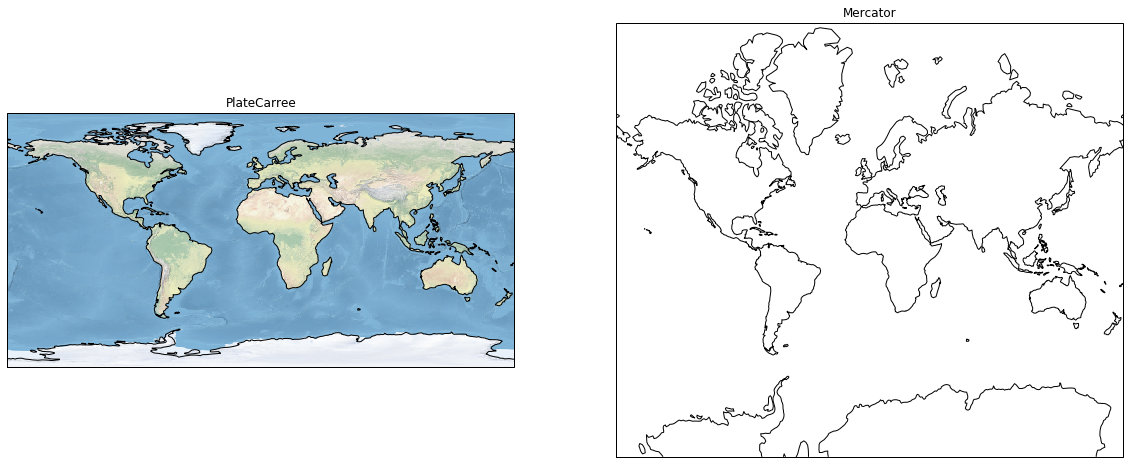

In [3]:
mapamundi = plt.subplot(121, projection=ccrs.PlateCarree(), title='PlateCarree')
mapamundi.coastlines()
mapamundi.stock_img()

mercator = plt.subplot(122, projection=ccrs.Mercator(), title='Mercator')
mercator.coastlines();


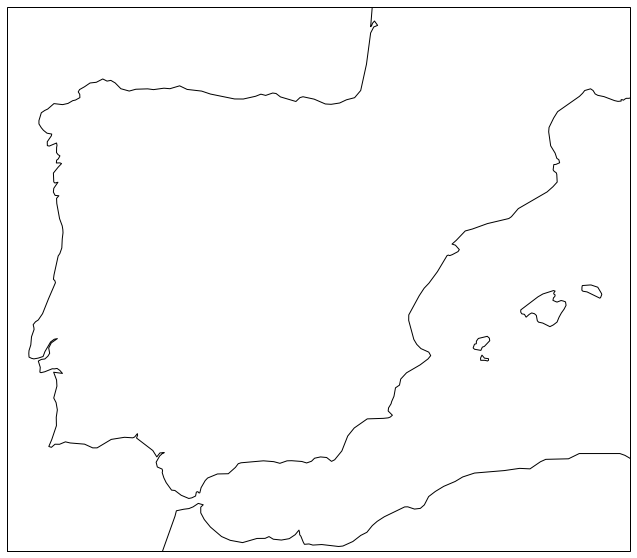

In [4]:
iberia = plt.axes(projection=ccrs.GOOGLE_MERCATOR)
iberia.coastlines(resolution='50m')

iberia.set_extent([-10, 5, 35, 45])

shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural', name=shapename)
states = (state for state in shpreader.Reader(states_shp).geometries())

In [5]:
URL = 'http://www.ine.es/jaxiT3/files/t/es/csv_sc/2852.csv?nocab=1'

In [6]:
# Descarga datos
poblacion = pd.read_csv(URL,
                        sep=';', encoding='utf-8',
                        na_values='..',
                        header=[4, 5],
                        index_col=0)[:-2]
# Limpia datos
poblacion.dropna(axis=1, inplace=True, how='all')
poblacion.dropna(axis=0, inplace=True, how='all')
poblacion.drop('Total Nacional', inplace=True)
poblacion.index = poblacion.index.map(lambda s: s.split()[0])

In [7]:
poblacion.columns = pd.MultiIndex.from_tuples(
    zip(poblacion.columns.get_level_values(0)[::22].repeat(22),
        poblacion.columns.get_level_values(1))
)

In [8]:
norm = matplotlib.colors.Normalize(vmin=poblacion.values.min(), vmax=poblacion.values.max())


In [9]:
def descarga_cartografia():
    ficheros = []
    URL = 'https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_ESP_shp.zip'
    try:
        temp_dir = tempfile.gettempdir()
        with request.urlopen(URL) as shapes_zip, zipfile.ZipFile(BytesIO(shapes_zip.read())) as download:
            ficheros = [download.extract(f, temp_dir)
                        for f in download.namelist()]
    except (zipfile.BadZipfile, zipfile.LargeZipFile) as exc:
        print('Error en fichero ZIP: {0}'.format(zip_file))
    for fichero in ficheros:
        if fichero.upper().endswith('.SHP') and 'ESP_2' in fichero.upper():
            return fichero

In [10]:
rdr = shpreader.Reader(descarga_cartografia())

In [11]:
def mapa_poblacion(año=2018, conjunto='Total', colores='Blues'):
    cmap = plt.cm.get_cmap(colores)
    iberia = plt.axes(projection=ccrs.GOOGLE_MERCATOR)
    iberia.coastlines(resolution='50m')
    iberia.set_extent([-10, 5, 35, 45])
    columna = poblacion[conjunto][año]
    
    for provincia in rdr.records():
        nombre_provincia, codigo_provincia = provincia.attributes['NAME_2'], provincia.attributes['CC_2']
        facecolor = cmap(norm(float(columna[codigo_provincia])))

        shape = ShapelyFeature([provincia.geometry],
                               ccrs.PlateCarree(),
                               facecolor=facecolor,
                               edgecolor='black')
        iberia.add_feature(shape)
    return iberia

In [12]:
interact(mapa_poblacion,
         año=poblacion.columns.get_level_values(1).unique(),
         conjunto=poblacion.columns.get_level_values(0).unique(),
         colores=[c for c in plt.colormaps() if not c.endswith('_r')]
);

interactive(children=(Dropdown(description='año', options=('2018', '2017', '2016', '2015', '2014', '2013', '20…